In [11]:
# Imports
import torch
import torch_cluster
from torch_geometric.nn import Node2Vec
from torch_geometric.datasets import Planetoid
from torchsummary import summary
from tqdm.notebook import tqdm

import ogb
# print(ogb.__version__)

import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

import time
import json
import copy
import random
import os.path as osp
from pprint import pprint

import importlib

import training
importlib.reload(training)
import graph_vis
importlib.reload(graph_vis)
import graph_creation
importlib.reload(graph_creation)
import utils
importlib.reload(utils)

from ogb.nodeproppred import Evaluator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [12]:
device = utils.set_seeds_and_device() # maybe return seed?

Using device: cpu
Random seed set to: 42


In [13]:
# data = graph_lib.load_dataset_cora()
# TODO: make the floe one function - into files like utils etc
# TODO: create grpahs from distr and clustercoeffs and test on those too 
# make the four test autmatickly run one after the other  
graph_community = graph_creation.graph_with_communities_generator(15,80)# 15,80
print(nx.average_clustering(graph_community))

graph_hierarchy = graph_creation.graph_with_hierarchy_generator(2, 10, False) # 2, 10
print(nx.average_clustering(graph_hierarchy))

# garph_vis.graph_visualizer(graph_community, layout='spring')
# graph_vis.graph_visualizer(graph_hierarchy, layout='bfs')  

data_community = utils.nx_to_pytorch_data_converter(graph_community)
data_hierarchy = utils.nx_to_pytorch_data_converter(graph_hierarchy)

# data = graph_lib.create_masks(data_community)
data_h = utils.create_masks(data_hierarchy)
data_c = utils.create_masks(data_community)


data_list=[data_c, data_h]
data_list=[data_c]

 => Using default probabilities
 => Graph saved to training_data/datasets/graphs/community_graph_15_80.gpickle
0.31199142946655933
2047
0.0


In [14]:
parameter_dicts = training.create_parameters_dict()


Running with q = {'embedding_dim': 128, 'walk_length': 20, 'context_size': 10, 'walks_per_node': 20, 'num_negative_samples': 1, 'p': 1, 'q': 200, 'sparse': True}
Model initialization parameters provided as dictionary.
Model initialized
Starting training for 6 epochs...


Epoch 1/6 Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 001, Loss: 9.0269, Acc: 0.1500, Duration: 13.79s
    New best model saved with accuracy: 0.1500


Epoch: 002, Loss: 7.4125, Acc: 0.3083, Duration: 11.50s
    New best model saved with accuracy: 0.3083


Epoch: 003, Loss: 6.0630, Acc: 0.4722, Duration: 11.71s
    New best model saved with accuracy: 0.4722


Epoch: 004, Loss: 5.0417, Acc: 0.7083, Duration: 11.89s
    New best model saved with accuracy: 0.7083


Epoch: 005, Loss: 4.3370, Acc: 0.8778, Duration: 11.34s
    New best model saved with accuracy: 0.8778


Epoch: 006, Loss: 3.8100, Acc: 0.9472, Duration: 10.75s
    New best model saved with accuracy: 0.9472

Training finished.
Total elapsed time: 71.00 seconds
Best test accuracy: 0.9472
Best model state saved to './training_data/models/node2vec_'


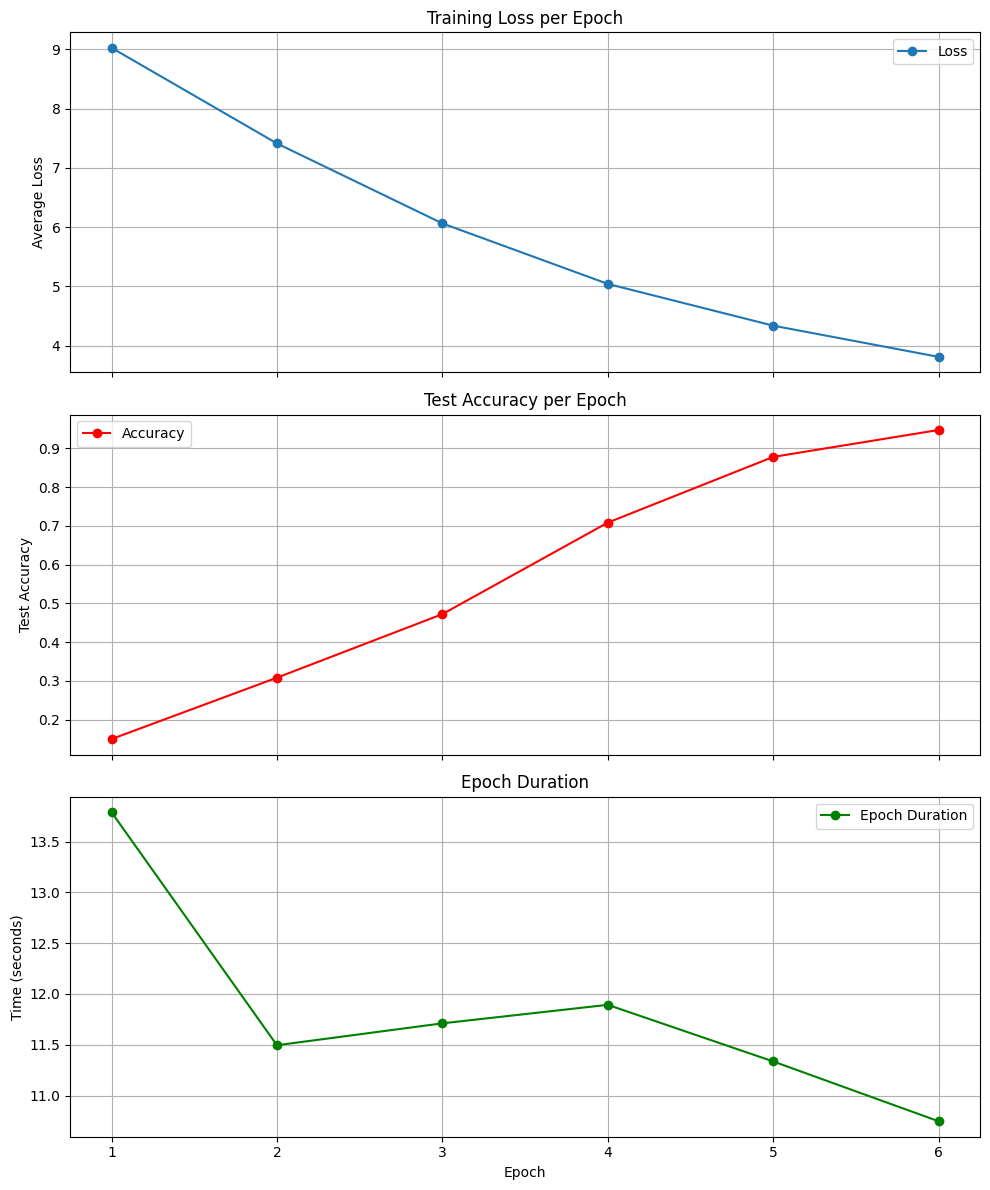

Running with p = {'embedding_dim': 128, 'walk_length': 20, 'context_size': 10, 'walks_per_node': 20, 'num_negative_samples': 1, 'p': 200, 'q': 1, 'sparse': True}
Model initialization parameters provided as dictionary.
Model initialized
Starting training for 6 epochs...


Epoch: 001, Loss: 9.4016, Acc: 0.1167, Duration: 12.03s
    New best model saved with accuracy: 0.1167


Epoch: 002, Loss: 8.0613, Acc: 0.1611, Duration: 10.91s
    New best model saved with accuracy: 0.1611


Epoch: 003, Loss: 6.8994, Acc: 0.2361, Duration: 10.92s
    New best model saved with accuracy: 0.2361


Epoch: 004, Loss: 5.8998, Acc: 0.3333, Duration: 11.51s
    New best model saved with accuracy: 0.3333


Epoch: 005, Loss: 5.0570, Acc: 0.4444, Duration: 10.60s
    New best model saved with accuracy: 0.4444


Epoch: 006, Loss: 4.3791, Acc: 0.5917, Duration: 10.77s
    New best model saved with accuracy: 0.5917

Training finished.
Total elapsed time: 66.76 seconds
Best test accuracy: 0.5917
Best model state saved to './training_data/models/node2vec_'


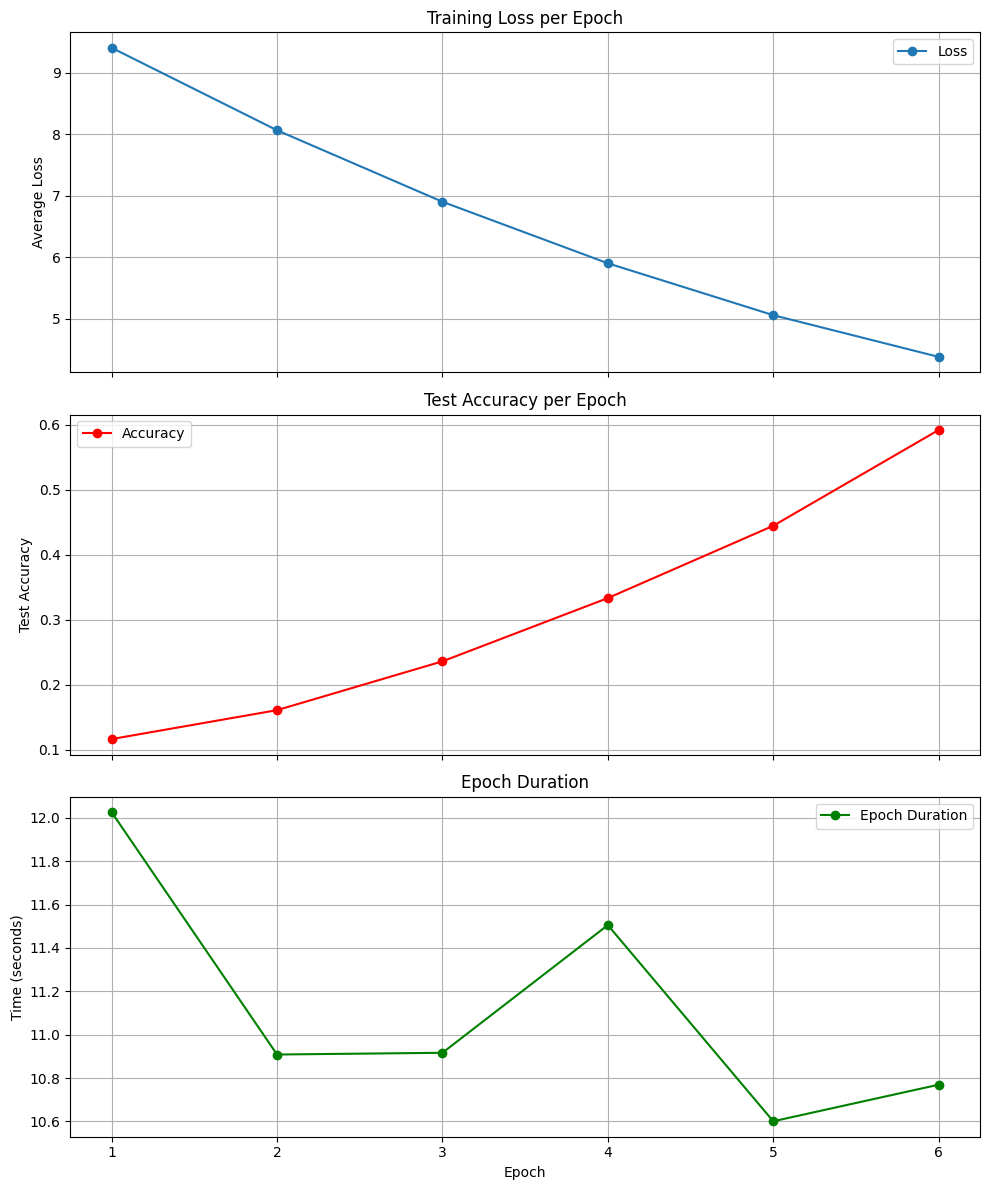

In [15]:
for data in data_list:
    for key, value in parameter_dicts.items():
        print(f"Running with {key} = {value}")
        # data = graph_lib.create_masks(data)
        model = training.model_init(value,data)
        
        loader, optimizer = training.set_loader_and_optimizer(model)
        num_training_epochs = 6 # Or 201, etc.

        best_state, training_history = training.model_training_n2v(
            model,
            value,
            data,
            loader,
            optimizer,
            num_training_epochs,
            device,
            model_save_path='./training_data/models/node2vec_' # Example save path
        )
        

In [21]:
model.eval()
with torch.no_grad():
    embeddings = model().cpu().numpy()  # shape: [num_nodes, embedding_dim]

labels = data.y.cpu().numpy()


# Split into train and test sets using masks
train_embeddings = embeddings[data.train_mask.cpu().numpy()]
train_labels = labels[data.train_mask.cpu().numpy()]

test_embeddings = embeddings[data.test_mask.cpu().numpy()]
test_labels = labels[data.test_mask.cpu().numpy()]

# Train logistic regression
clf = LogisticRegression(max_iter=500)
clf.fit(train_embeddings, train_labels)

# Predict and evaluate
preds = clf.predict(test_embeddings)
acc = accuracy_score(test_labels, preds)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.5917


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assume embeddings, data.train_mask, data.test_mask, and data.y are already defined

# Get train/test splits
train_embeddings = embeddings[data.train_mask.cpu().numpy()]
train_labels = data.y.cpu().numpy()[data.train_mask.cpu().numpy()]

test_embeddings = embeddings[data.test_mask.cpu().numpy()]
test_labels = data.y.cpu().numpy()[data.test_mask.cpu().numpy()]

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_embeddings, train_labels)

# Predict and evaluate
preds = rf.predict(test_embeddings)
acc = accuracy_score(test_labels, preds)
print(f"Random Forest Test Accuracy: {acc:.4f}")

Random Forest Test Accuracy: 0.3639


In [23]:
from xgboost import XGBClassifier

# Assume embeddings, data.train_mask, data.test_mask, and data.y are already defined

# Get train/test splits
train_embeddings = embeddings[data.train_mask.cpu().numpy()]
train_labels = data.y.cpu().numpy()[data.train_mask.cpu().numpy()]

test_embeddings = embeddings[data.test_mask.cpu().numpy()]
test_labels = data.y.cpu().numpy()[data.test_mask.cpu().numpy()]

# Train XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(train_embeddings, train_labels)

# Predict and evaluate
preds = xgb.predict(test_embeddings)
acc = accuracy_score(test_labels, preds)
print(f"XGBoost Test Accuracy: {acc:.4f}")

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14], got [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]

In [24]:
from sklearn.model_selection import StratifiedShuffleSplit

labels = data.y.cpu().numpy()
embeddings = embeddings  # already computed

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(sss.split(embeddings, labels))

train_embeddings = embeddings[train_idx]
train_labels = labels[train_idx]
test_embeddings = embeddings[test_idx]
test_labels = labels[test_idx]

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(train_embeddings, train_labels)

preds = xgb.predict(test_embeddings)
acc = accuracy_score(test_labels, preds)
print(f"XGBoost Test Accuracy: {acc:.4f}")

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14], got [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]

In [ ]:
# TODO: save previous best result with model? check out a library for this?
# model,model_init_params = graph_lib.model_init_from_file('./training_data/models/node2vec_embedding_dim_128_walk_length_20_context_size_10_walks_per_node_20_num_negative_samples_1_p_200_q_1_sparse_True.json', data)

In [ ]:
model = training.model_init(
    model_init_params_p,
    data
)

loader, optimizer = training.set_loader_and_optimizer(model)

In [ ]:
num_training_epochs = 6 # Or 201, etc.

best_state, training_history = training.model_training_n2v(
    model,
    model_init_params_q,
    data,
    loader,
    optimizer,
    num_training_epochs,
    device,
    model_save_path='./training_data/models/node2vec_' # Example save path
)

Starting training for 6 epochs...


Epoch: 001, Loss: 7.5788, Acc: 0.4049, Duration: 13.21s
    New best model saved with accuracy: 0.4049


Epoch: 002, Loss: 5.6322, Acc: 0.4130, Duration: 13.21s
    New best model saved with accuracy: 0.4130


Epoch: 003, Loss: 4.8283, Acc: 0.4098, Duration: 15.97s


Epoch: 004, Loss: 4.2908, Acc: 0.4163, Duration: 16.26s
    New best model saved with accuracy: 0.4163


KeyboardInterrupt: 